In [3]:
from transformers import LlamaForCausalLM, LlamaTokenizer, LlamaConfig
from model import InstructGLM
from bertviz import model_view, head_view
import torch
import random
import os 
import numpy as np

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)
# model
model_name = '/home/zuographgroup/zhr/model/vicuna-7b-v1.5'
device = torch.device('cuda:1')
tokenizer = LlamaTokenizer.from_pretrained(model_name)
tokenizer.padding_side = 'left'
special={'additional_special_tokens': ['<Node {}>'.format(i) for i in range(1, 21)]}   # Add a new special token as place holder
tokenizer.add_special_tokens(special)
config = LlamaConfig.from_pretrained(model_name)
model = InstructGLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16, 
    config=config,
#     use_cache=True, 
#     low_cpu_mem_usage=True,
    device_map={"":device}
    )

[2024-05-08 10:08:52,582] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
import argparse
from model import GraphEncoder
import numpy as np
from circuitsvis.attention import attention_patterns
from matplotlib import pyplot as plt

parser = argparse.ArgumentParser()
args = parser.parse_args(args=[])
args.gnn_type = 'GraphSAGE'
args.gnn_output = 4096
args.num_token = 5
args.gnn_input = 128
args.gt_layers = 2
args.att_d_model = 2048
args.graph_pooling = 'sum'
args.edge_dim = None
args.dropout = 0.5
args.graph_unsup = False
args.prefix = 'graphsage_1000tp_5token_512_neg0_arxiv_linear_2_3400'
args.dataset = 'arxiv'
args.mask_token_list = None

In [5]:
# first model
first_model_path = './saved_model/first_model/{}_fm_{}_epoch{}_{}.pth'
llama_embeds = model.get_input_embeddings().weight.data
node_token=torch.zeros(110, llama_embeds.shape[1]).to(device=device, dtype=llama_embeds.dtype)
llama_embeds=torch.cat([llama_embeds, node_token],dim=0)
first_model = GraphEncoder(args, llama_embed=llama_embeds).to(device, dtype=torch.bfloat16)
first_model.load_state_dict(torch.load(first_model_path.format(args.prefix, args.dataset, 0, 'end')))

<All keys matched successfully>

In [6]:
# 获取输入
import pandas as pd
from torch_geometric.data import Data, Batch

add_tokens = " ".join([f"<Node {i}>" for i in range (1, 1 + 5)])
df = pd.read_json('./instruction/pubmed/mark_ans.json')
df = pd.read_json('./instruction/pubmed/case_study.json')
# print(df[df.mark == 2])
idx = 0
instruction = df.iloc[idx]
llm_out, glm_out, real_out = instruction['llm_out'], instruction['glm_out'], instruction['output']
print(llm_out, glm_out, real_out)
raw_prompt = instruction['prompt']
prompt = (raw_prompt.split('Abstract: ')[0] + 'Title: ' + raw_prompt.split('Title: ')[1])
llm_prompt = 'Given a paper with the following information:\n' + 'Title: ' + raw_prompt.split('Title: ')[1]
# llm_prompt = 'Given a paper with the following information:\n' + 'Abstract: ' + raw_prompt.split('Abstract: ')[1]
print(prompt)
print(llm_prompt)

The paper is likely to involve "Type 1 diabetes" as the title specifically mentions "cell-mediated immunity" which is a key feature of this type of diabetes. In addition, the mention of "end-stage renal disease" suggests that the diabetes has progressed to a severe stage, which is more commonly seen in Type 1 diabetes than in Type 2 diabetes. Experimentally induced diabetes is not specified in the title, so it is not the most likely answer. Type 1 diabetes Type 1 diabetes
Given a representation of a paper: <Node 1>, with the following information: 
Title: Cell-mediated immunity and biological response modifiers in insulin-dependent diabetes mellitus complicated by end-stage renal disease. 
 Question: Which diabetes does this paper involve? Please directly give the most likely answer from the following diabetes: "Type 1 diabetes", "Type 2 diabetes", "Experimentally induced diabetes".
Given a paper with the following information:
Title: Cell-mediated immunity and biological response modi

In [7]:
llama_prompt = f"""USER: {llm_prompt} ASSISTANT:"""
print(llama_prompt)
glm_prompt = f"""USER: {prompt.replace(": <Node 1>", add_tokens)} ASSISTANT:"""
print(glm_prompt)
llama_prompt_ans = f"""USER: {llm_prompt} ASSISTANT: {glm_out}"""
print(llama_prompt_ans)
glm_prompt_ans = f"""USER: {prompt.replace(": <Node 1>", add_tokens)} ASSISTANT: {glm_out}"""
print(glm_prompt_ans)

# glm_token = tokenizer.encode(glm_out+'</s>')[1:]
# llm_token = tokenizer.encode(llm_out+'</s>')[1:]

# def logits_diff(input, model, glm_token, llm_token):
#     min_len = min(len(glm_token), len(llm_token))
#     attn = torch.eye(min_len).bool()
#     pred = model.lm_head(input).softmax(dim=-1)

#     return pred[:, -len(glm_token)-1:-1, glm_token[:min_len]].detach().cpu().to(torch.float32)[:, attn].mean()
#     pred[:, -len(glm_token)-1:-1, llm_token[:min_len]].detach().cpu().to(torch.float32)[:, attn].mean()

glm_token = tokenizer.encode(glm_out)[1]
llm_token = tokenizer.encode(llm_out)[1]

def logits_diff(input, model, glm_token, llm_token):
    pred = model.lm_head(input).softmax(dim=-1)

    return pred[:, -1, glm_token].detach().cpu().to(torch.float32)
    pred[:, -1, llm_token].detach().cpu().to(torch.float32)

USER: Given a paper with the following information:
Title: Cell-mediated immunity and biological response modifiers in insulin-dependent diabetes mellitus complicated by end-stage renal disease. 
 Question: Which diabetes does this paper involve? Please directly give the most likely answer from the following diabetes: "Type 1 diabetes", "Type 2 diabetes", "Experimentally induced diabetes". ASSISTANT:
USER: Given a representation of a paper<Node 1> <Node 2> <Node 3> <Node 4> <Node 5>, with the following information: 
Title: Cell-mediated immunity and biological response modifiers in insulin-dependent diabetes mellitus complicated by end-stage renal disease. 
 Question: Which diabetes does this paper involve? Please directly give the most likely answer from the following diabetes: "Type 1 diabetes", "Type 2 diabetes", "Experimentally induced diabetes". ASSISTANT:
USER: Given a paper with the following information:
Title: Cell-mediated immunity and biological response modifiers in insulin

In [8]:
final_prompt = glm_prompt_ans + '</s>'
final_prompt = glm_prompt
input_ids = tokenizer(
    final_prompt,
    return_tensors="pt"
).input_ids
attention_mask=input_ids.ne(tokenizer.pad_token_id)

graph = Data()
graph.edge_index = torch.LongTensor(instruction['edge_index'])
graph.edge_attr = None
node_list = instruction['node_set']
graph.x = torch.tensor(instruction['x'], dtype=torch.bfloat16)
graph.lp = False

is_node = (input_ids >= 32000)
extra_num = is_node.sum()

graph = Batch.from_data_list([graph])

# train
embeds = first_model(
    input_ids=input_ids.to(device),
    is_node=is_node.to(device),
    graph=graph.to(device),
    use_llm=False
)
results = model.g_step(in_embeds=embeds, attention_mask=attention_mask)
# results = model.generate(input_ids.to(device), attention_mask=attention_mask)
outputs = tokenizer.decode(results[0], skip_special_tokens=True).strip()
print(outputs, glm_out)

clean_output = model(inputs_embeds=embeds, attention_mask=attention_mask, output_attentions=True, output_hidden_states=True)
print(clean_output['attentions'][-1].shape)

clean_logits_diff = logits_diff(clean_output['hidden_states'][-1], model, glm_token, llm_token)
print(clean_logits_diff)

Type 1 diabetes Type 1 diabetes
torch.Size([1, 32, 116, 116])
tensor([0.8711])


In [9]:
final_prompt = glm_prompt_ans + '</s>'
final_prompt = glm_prompt
input_ids = tokenizer(
    final_prompt,
    return_tensors="pt"
).input_ids
attention_mask=input_ids.ne(tokenizer.pad_token_id)

special = ["<Node 1>", "<Node 2>", "<Node 3>", "<Node 4>", "<Node 5>"]
select_id = [i for i in range(len(tokenizer.tokenize(final_prompt))) if tokenizer.tokenize(final_prompt)[i] in special]
print(select_id)
attention_mask[:, select_id] = False

is_node = (input_ids >= 32000)
extra_num = is_node.sum()

# train
embeds = first_model(
    input_ids=input_ids.to(device),
    is_node=is_node.to(device),
    graph=graph.to(device),
    use_llm=True
)
results = model.g_step(in_embeds=embeds, attention_mask=attention_mask)
# results = model.generate(input_ids.to(device), attention_mask=attention_mask)
outputs = tokenizer.decode(results[0], skip_special_tokens=True).strip()
print(outputs, llm_out)

corrupted_output = model(inputs_embeds=embeds, attention_mask=attention_mask, output_attentions=True, output_hidden_states=True)
print(corrupted_output['attentions'][-1].shape)

corrupted_logits_diff = logits_diff(corrupted_output['hidden_states'][-1], model, glm_token, llm_token)
print(corrupted_logits_diff)

[9, 10, 11, 12, 13]
The paper is likely to involve "Type 1 diabetes" as the title specifically mentions "cell-mediated immunity" and "biological response modifiers," which are key aspects of the immune system's response in Type 1 diabetes. In contrast, Type 2 diabetes is more closely associated with insulin resistance and the role of insulin in regulating glucose metabolism, rather than immune system dysfunction. Experimentally induced diabetes typically refers to a model of diabetes induced in animals or in vitro studies, which is different from The paper is likely to involve "Type 1 diabetes" as the title specifically mentions "cell-mediated immunity" which is a key feature of this type of diabetes. In addition, the mention of "end-stage renal disease" suggests that the diabetes has progressed to a severe stage, which is more commonly seen in Type 1 diabetes than in Type 2 diabetes. Experimentally induced diabetes is not specified in the title, so it is not the most likely answer.
to

In [10]:
res = torch.zeros((32, 5))
for layer_id in range(32):
    for idx, token_id in enumerate(select_id):
        attention_mask[:, select_id] = True
        if token_id in select_id:

            attention_mask[:, token_id] = False
        def modify_hidden_states(module, input, output):
            output[0][:, select_id] = clean_output['hidden_states'][layer_id+1][:, select_id]
            return output

        h = model.model.layers[layer_id].register_forward_hook(modify_hidden_states)
        patched_output = model(inputs_embeds=embeds, attention_mask=attention_mask, output_attentions=True, output_hidden_states=True)
        h.remove()
        patched_logit_diff = logits_diff(patched_output['hidden_states'][-1], model, glm_token, llm_token)
        res[layer_id, idx] = patched_logit_diff.detach().cpu()

diff = 1 - ((res - corrupted_logits_diff)/(clean_logits_diff - corrupted_logits_diff))

In [11]:
import torch.nn.functional as F

diff_clip = torch.clamp(diff, 0, 1)
b = F.normalize(diff_clip, p=1, dim=1)

In [14]:
import plotly.express as px

title = "Effect of patching"
fig = px.imshow(
    diff_clip,
    title=title if title else "",
    color_continuous_scale="RdBu",
    color_continuous_midpoint=0,
)

fig.update_layout(
    width = 500,
    coloraxis_colorbar=dict(
        title="",
        thicknessmode="pixels",
        thickness=50,
        lenmode="pixels",
        len=250,
        yanchor="top",
        y=1,
        ticks="outside",
    ),
)
fig.update_layout(
    yaxis_title="",
    xaxis_title="",
    xaxis_range=[-0.5, diff.shape[1] - 0.5],
    showlegend=True,
    legend=dict(x=-0.1),
)
fig.show()

In [38]:
# eval
# special = ["<Node 1>", "<Node 2>", "<Node 3>", "<Node 4>", "<Node 5>"]
# select_id = [i for i in range(len(tokenizer.tokenize(final_prompt))) if tokenizer.tokenize(final_prompt)[i] in special]
# print(select_id)
# attention_mask[:, select_id] = False


Type 1 diabetes.


In [37]:
# train
embeds = first_model(
    input_ids=input_ids.to(device),
    is_node=is_node.to(device),
    graph=graph.to(device),
    use_llm=True
)
output = model(inputs_embeds=embeds, labels=targets, attention_mask=attention_mask, output_attentions=True, output_hidden_states=True)
print(output['attentions'][0].shape)
print(output['hidden_states'][-1].shape)
print(output['loss'])

ValueError: Expected input batch_size (97) to match target batch_size (104).

5167
▁Type


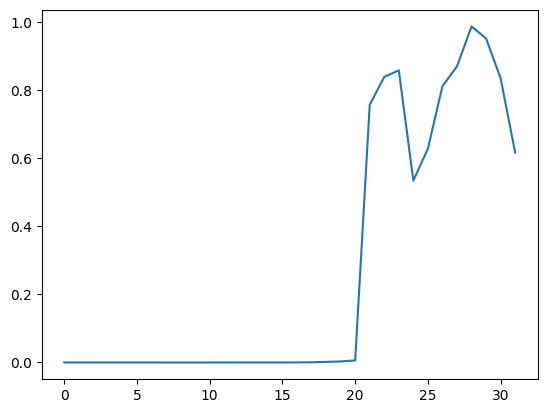

In [90]:
# logits of each layer
logits_ls = []
ans_token = tokenizer.encode(glm_out)[1]
print(ans_token)
print(tokenizer.convert_ids_to_tokens(ans_token))
for i in range(1, 33):
    layer_pred = model.lm_head(output['hidden_states'][i]).softmax(dim=-1)
    logits_ls.append(layer_pred[:, -target_len-2, ans_token].detach().cpu().to(torch.float32).numpy())
plt.plot(np.arange(32), logits_ls)
plt.show()

In [44]:
attn = output['attentions']
tokens = tokenizer.encode(final_prompt)
tokens = tokenizer.convert_ids_to_tokens(tokens)
print(tokens)
html = head_view(attn, tokens, include_layers=[0, 31], heads=[0], html_action='return')
# html = model_view(attn, tokens, include_layers=[0, 31], html_action='return')
with open("./head_view.html", "w") as file:
    file.write(html.data)

['<s>', '▁US', 'ER', ':', '▁Given', '▁a', '▁representation', '▁of', '▁a', '▁paper', '<Node 1>', '<Node 2>', '<Node 3>', '<Node 4>', '<Node 5>', '▁,', '▁with', '▁the', '▁following', '▁information', ':', '▁', '<0x0A>', 'Title', ':', '▁Effect', 's', '▁of', '▁', '1', '5', '-', 'month', '▁al', 'd', 'ose', '▁re', 'duct', 'ase', '▁in', 'hib', 'ition', '▁with', '▁fid', 'ar', 'est', 'at', '▁on', '▁the', '▁experimental', '▁di', 'ab', 'etic', '▁ne', 'urop', 'ath', 'y', '▁in', '▁r', 'ats', '.', '▁', '<0x0A>', '▁Question', ':', '▁Which', '▁di', 'ab', 'etes', '▁does', '▁this', '▁paper', '▁involve', '?', '▁Please', '▁directly', '▁give', '▁the', '▁most', '▁likely', '▁answer', '▁from', '▁the', '▁following', '▁di', 'ab', 'etes', ':', '▁"', 'Type', '▁', '1', '▁di', 'ab', 'etes', '",', '▁"', 'Type', '▁', '2', '▁di', 'ab', 'etes', '",', '▁"', 'Ex', 'periment', 'ally', '▁induced', '▁di', 'ab', 'etes', '".', '▁A', 'SS', 'IST', 'ANT', ':', '▁Ex', 'periment', 'ally', '▁induced', '▁di', 'ab', 'etes', '.', '</s>

In [41]:
layer_num = 30
layer_attn = output['attentions'][layer_num][0]
tokens = tokenizer.encode(final_prompt)
tokens = tokenizer.convert_ids_to_tokens(tokens)
vis_tokens = [token[1:-1] if token in add_tokens else token for token in tokens]
print(vis_tokens)
vis = attention_patterns(tokens=vis_tokens, attention=layer_attn)
vis_path = f"./llm_vis_{idx}_{layer_num}.html"
with open(vis_path, "w") as f:
    f.write(vis._repr_html_())

['<s>', '▁US', 'ER', ':', '▁Given', '▁a', '▁representation', '▁of', '▁a', '▁paper', 'Node 1', 'Node 2', 'Node 3', 'Node 4', 'Node 5', '▁,', '▁with', '▁the', '▁following', '▁information', ':', '▁', '<0x0A>', 'Title', ':', '▁Cy', 'top', 'rote', 'ction', '▁of', '▁pan', 'cre', 'atic', '▁is', 'lets', '▁before', '▁and', '▁soon', '▁after', '▁trans', 'plant', 'ation', '▁by', '▁gene', '▁transfer', '▁of', '▁the', '▁anti', '-', 'ap', 'opt', 'otic', '▁B', 'cl', '-', '', '▁gene', '.', '▁', '<0x0A>', '▁Question', ':', '▁Which', '▁di', 'ab', 'etes', '▁does', '▁this', '▁paper', '▁involve', '?', '▁Please', '▁directly', '▁give', '▁the', '▁most', '▁likely', '▁answer', '▁from', '▁the', '▁following', '▁di', 'ab', 'etes', ':', '▁"', 'Type', '▁', '', '▁di', 'ab', 'etes', '",', '▁"', 'Type', '▁', '', '▁di', 'ab', 'etes', '",', '▁"', 'Ex', 'periment', 'ally', '▁induced', '▁di', 'ab', 'etes', '".', '▁A', 'SS', 'IST', 'ANT', ':', '▁Ex', 'periment', 'ally', '▁induced', '▁di', 'ab', 'etes', '</s>']


In [93]:
layer_num = 31
attn = output['attentions'][layer_num][0].mean(dim=0)
# attn = output['attentions'][layer_num][0][24]
scale = attn.sum(dim=0)
tokens = tokenizer.encode(final_prompt)
tokens = tokenizer.convert_ids_to_tokens(tokens)
select_id = []
info_id = 0
query_id = 0
answer_id = 0
for i in range(len(tokens)):
    if tokens[i] in ['<Node 1>', '<Node 2>', '<Node 3>', '<Node 4>', '<Node 5>']:
        select_id.append(i)
    if tokens[i] == '▁Question':
        query_id = i
    elif tokens[i] == 'Title' and tokens[i-1] == '<0x0A>':
        info_id = i
    elif tokens[i] == 'IST' and tokens[i-1] == 'SS':
        answer_id = i-1
select_attn = attn[-target_len-1, :]
print(select_attn.shape)
print(select_id, info_id, query_id, answer_id)

torch.Size([121])
[10, 11, 12, 13, 14] 23 59 110


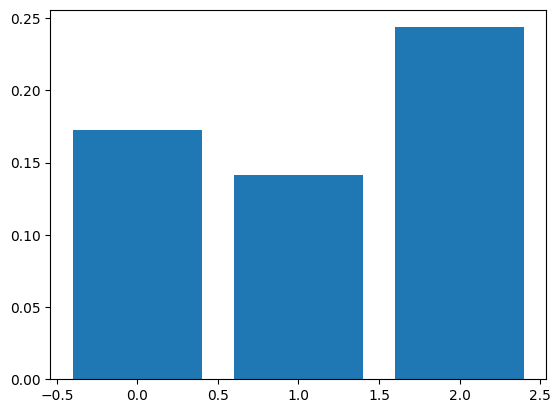

In [94]:
scale_np = scale.detach().cpu().to(torch.float32).numpy()
y = select_attn.detach().cpu().to(torch.float32).numpy()
x = np.arange(y.shape[0])
y_max = np.array([y.max() for _ in range(y.shape[0])])

y_mean = np.array([y[select_id].sum(), y[info_id:query_id].sum(), y[query_id:answer_id].sum()])
# plt.plot(x, y, label=f'node {i}')
plt.bar(np.arange(3), y_mean)

# plt.fill_between(x[:info_id], y_max[:info_id], 0, facecolor = "lightgreen")
# plt.fill_between(x[info_id:query_id], y_max[info_id:query_id], 0, facecolor = "skyblue")
# plt.fill_between(x[query_id:], y_max[query_id:], 0, facecolor = "lightgray")
plt.show()

In [63]:
width = 0.1  # 柱状图的宽度，可以根据自己的需求和审美来改
offset = [- width*2, - width+0.01, 0.02, width+ 0.03, width*2 + 0.04]

for i in range(5):
    y_sq = np.array([y[:info_id, i].mean(), y[info_id:query_id, i].mean(), y[query_id:answer_id, i].mean(), y[answer_id:, i].mean()])
    # y_sq = np.array([(y[:info_id, i]/scale_np[select_id[i]]).mean(), (y[info_id:query_id, i]/scale_np[select_id[i]]).mean(),
    # (y[query_id:answer_id, i]/scale_np[select_id[i]]).mean(), (y[answer_id:, i]/scale_np[select_id[i]]).mean()])
    plt.bar(np.arange(4)+offset[i], y_sq, label=f"node {i}", width=width)
plt.legend()
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

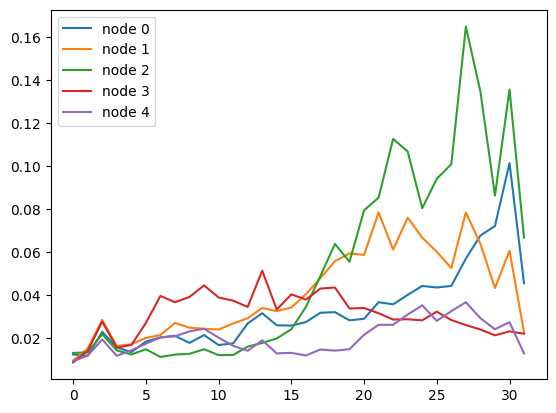

In [14]:
node_attn_ls = []
for i in range(32):
    layer_attn = output['attentions'][i][0].mean(dim=0)
    node_attn = layer_attn[:, select_id].mean(dim=0)
    node_attn_ls.append(node_attn)
node_attn_ls = torch.stack(node_attn_ls, dim=0).detach().cpu().to(torch.float32).numpy()
for i in range(5):
    plt.plot(np.arange(32), node_attn_ls[:, i], label=f"node {i}")
plt.legend()
plt.show()
